# DISCRETE WAVELET TRANSFORM - OFDM

## Import Packages

In [30]:

import numpy as np
import pywt
import cv2
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

# Suppress PyWavelets warnings that occur when input data length is not perfectly suited for max DWT level.
# This often happens when N_SUBCARRIERS is, for example, 256, and 'db4' wavelet has a filter length of 4.
# For practical purposes, these warnings can be ignored if the reconstruction works correctly.
warnings.filterwarnings("ignore", message="The wavelet w's filter length is 4. When input data length is 256, pywt.dwt_max_level will return 6. Max level should be a little less.")


## System Parameters

In [31]:

## ============================================================================================================== ##
##                                              SYSTEM PARAMETERS                                                ##
## ============================================================================================================== ##
N_SUBCARRIERS = 256   # Number of subcarriers in the DWT-OFDM system. This also defines the block size for DWT.
CP_RATIO = 1/4        # Cyclic Prefix ratio. A portion of the end of the symbol is copied to the beginning.
CP_LENGTH = int(N_SUBCARRIERS * CP_RATIO) # Length of the Cyclic Prefix.
K = 1                 # Number of users (mobile devices) transmitting simultaneously.
M_ANTENNAS = 1        # Number of antennas at the Base Station (BS). For Massive MIMO, M_ANTENNAS >> K.
MOD_ORDER_BITS = 2    # Modulation order in bits. 1 for BPSK, 2 for QPSK.
SNR_DB = 20           # Signal-to-noise ratio in decibels (dB) for the wireless channel.
WAVELET = 'db4'       # Type of wavelet to use for the Discrete Wavelet Transform (DWT), e.g., 'db4' (Daubechies 4).


## MODULATION & DEMODULATION

In [32]:

## ============================================================================================================== ##
##                                           MODULATION & DEMODULATION                                           ##
## ============================================================================================================== ##

def modulate_psk(bits, mod_order_bits):
    """
    Modulates an array of binary bits into PSK (Phase Shift Keying) symbols.

    Args:
        bits (np.array): An array of 0s and 1s representing the binary data.
        mod_order_bits (int): The number of bits per symbol (e.g., 1 for BPSK, 2 for QPSK).

    Returns:
        np.array: An array of complex PSK symbols.
    """
    # CRITICAL FIX: Ensure bits are treated as integers (0 or 1) for arithmetic.
    # np.unpackbits returns uint8, which can lead to unexpected overflow/wraparound
    # behavior during arithmetic operations if not cast. Casting to int ensures correct behavior.
    bits = bits.astype(int) 

    if mod_order_bits == 1: # BPSK (Binary Phase Shift Keying)
        # BPSK maps 0 to -1 and 1 to 1.
        return 2 * bits - 1
    elif mod_order_bits == 2: # QPSK (Quadrature Phase Shift Keying)
        # QPSK maps pairs of bits to one of four constellation points.
        # Example: (0,0) -> -1-1j, (0,1) -> -1+1j, (1,0) -> 1-1j, (1,1) -> 1+1j
        # Then normalized by sqrt(2) for unit average power.
        bits_reshaped = bits.reshape(-1, 2) # Reshape bits into pairs (e.g., [[0,1], [1,0], ...])
        
        # Map first bit of pair to real part, second bit to imaginary part.
        # (2*bit - 1) converts 0 to -1 and 1 to 1.
        symbols = (2 * bits_reshaped[:, 0] - 1) + 1j * (2 * bits_reshaped[:, 1] - 1)
        
        # Normalize by sqrt(2) to ensure average symbol power is 1.
        # For QPSK, ideal constellation points are at ( +/- 1/sqrt(2) +/- j/sqrt(2) ).
        return symbols / np.sqrt(2) 
    else:
        # Extend this function for higher order modulations (e.g., 16-QAM) if needed.
        raise NotImplementedError(f"{2**mod_order_bits}-PSK/QAM not implemented. Only BPSK/QPSK.")

def demodulate_psk(rx_symbols, mod_order_bits):
    """
    Demodulates received PSK symbols back into binary bits.

    Args:
        rx_symbols (np.array): An array of received complex PSK symbols.
        mod_order_bits (int): The number of bits per symbol.

    Returns:
        np.array: An array of demodulated 0s and 1s.
    """
    if mod_order_bits == 1: # BPSK
        # For BPSK, if real part > 0, it's a 1; otherwise, it's a 0.
        return (np.real(rx_symbols) > 0).astype(int)
    elif mod_order_bits == 2: # QPSK
        # For QPSK, recover real and imaginary bits separately.
        # If real part > 0, real bit is 1; else 0. Same for imaginary part.
        real_bits = (np.real(rx_symbols) > 0).astype(int)
        imag_bits = (np.imag(rx_symbols) > 0).astype(int)
        
        # Stack and flatten to interleave bits: [real_bit1, imag_bit1, real_bit2, imag_bit2, ...]
        return np.stack((real_bits, imag_bits), axis=-1).flatten()
    else:
        raise NotImplementedError(f"{2**mod_order_bits}-PSK/QAM not implemented. Only BPSK/QPSK.")

def add_cyclic_prefix(ofdm_symbol, cp_length):
    """
    Adds a cyclic prefix to an OFDM/DWT-OFDM symbol.
    Copies the last 'cp_length' samples to the beginning of the symbol.

    Args:
        ofdm_symbol (np.array): The OFDM/DWT-OFDM symbol (time-domain).
        cp_length (int): The length of the cyclic prefix.

    Returns:
        np.array: The symbol with the cyclic prefix added.
    """
    return np.concatenate((ofdm_symbol[-cp_length:], ofdm_symbol))

def remove_cyclic_prefix(rx_ofdm_symbol, cp_length):
    """
    Removes the cyclic prefix from a received OFDM/DWT-OFDM symbol.

    Args:
        rx_ofdm_symbol (np.array): The received symbol (time-domain) including the cyclic prefix.
        cp_length (int): The length of the cyclic prefix.

    Returns:
        np.array: The symbol with the cyclic prefix removed.
    """
    return rx_ofdm_symbol[cp_length:]


## TRANSMITTER

In [33]:

## ============================================================================================================== ##
##                                                 TRANSMITTER                                                   ##
## ============================================================================================================== ##

def dwt_ofdm_transmitter(image_path, N_subcarriers, K_users, mod_order_bits, wavelet_name, cp_length):
    """
    Simulates the DWT-OFDM transmitter chain.
    Reads an image, converts it to bits, modulates, applies DWT, adds CP, and prepares symbols for transmission.

    Args:
        image_path (str): Path to the input image (e.g., "flower.png").
        N_subcarriers (int): Number of subcarriers (DWT block size).
        K_users (int): Number of users.
        mod_order_bits (int): Modulation order in bits.
        wavelet_name (str): Name of the wavelet to use (e.g., 'db4').
        cp_length (int): Length of the cyclic prefix.

    Returns:
        tuple:
            - final_tx_symbols_per_user (list of np.array): Transmitted DWT-OFDM symbols for each user.
            - img_resized.shape (tuple): Shape of the resized original image.
            - total_image_bits (np.array): Original flattened image bits.
            - coeff_info_per_user_list (list): List of dictionaries containing DWT coefficient lengths for each block and user.
    """
    # 1. Image Loading and Preprocessing
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) # Read image as grayscale
    if img is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    
    img_resized = cv2.resize(img, (N_subcarriers, N_subcarriers)) # Resize image to N_subcarriers x N_subcarriers
    img_flat_bytes = img_resized.flatten().astype(np.uint8) # Flatten the image into a 1D array of bytes (0-255)
    total_image_bits = np.unpackbits(img_flat_bytes) # Convert each byte into 8 individual bits (0 or 1, as uint8 type)
    
    bits_per_modulated_symbol = mod_order_bits
    
    # Determine the maximum level of DWT decomposition possible for the given N_subcarriers and wavelet.
    dwt_max_level = pywt.dwt_max_level(N_subcarriers, wavelet_name)
    if dwt_max_level == 0:
        raise ValueError(f"Cannot decompose {N_subcarriers} with wavelet '{wavelet_name}'. "
                         "N_SUBCARRIERS must be large enough for at least one level of decomposition.")
    
    # Calculate how many modulated symbols are needed to transmit all image bits.
    num_modulated_symbols = int(np.ceil(len(total_image_bits) / bits_per_modulated_symbol))
    
    # Each DWT-OFDM block input has N_subcarriers complex symbols.
    symbols_per_dwt_ofdm_block_input = N_subcarriers
    
    # Calculate the total number of DWT-OFDM blocks required across all users.
    num_blocks_needed_total = int(np.ceil(num_modulated_symbols / symbols_per_dwt_ofdm_block_input))
    
    # Calculate the total number of modulated symbols to process, padded to fit full blocks.
    total_symbols_to_process = num_blocks_needed_total * symbols_per_dwt_ofdm_block_input
    
    # Pad the image bits with zeros if necessary to make them perfectly fit into modulated symbols and DWT-OFDM blocks.
    padded_image_bits = np.pad(total_image_bits, (0, total_symbols_to_process * bits_per_modulated_symbol - len(total_image_bits)), 'constant')
    
    # --- DEBUGGING PRINT (TRANSMITTER - before modulation) ---
    print(f"DEBUG (Tx): Padded image bits dtype: {padded_image_bits.dtype}")
    print(f"DEBUG (Tx): Padded image bits unique values: {np.unique(padded_image_bits)}") # Expected: [0, 1]
    print(f"DEBUG (Tx): Padded image bits length: {len(padded_image_bits)}")
    # --- END DEBUGGING PRINT (TRANSMITTER) ---

    # 2. Modulation: Convert padded bits into complex PSK symbols.
    all_modulated_symbols = modulate_psk(padded_image_bits, mod_order_bits)

    # --- DEBUGGING PRINT (TRANSMITTER - after initial modulation) ---
    # Check the range of the complex symbols after modulation. For normalized QPSK, expected range is approx [-0.707, 0.707].
    print(f"DEBUG (Tx): all_modulated_symbols real part range after modulation: [{all_modulated_symbols.real.min():.4f}, {all_modulated_symbols.real.max():.4f}]")
    print(f"DEBUG (Tx): all_modulated_symbols imag part range after modulation: [{all_modulated_symbols.imag.min():.4f}, {all_modulated_symbols.imag.max():.4f}]")
    # --- END DEBUGGING PRINT (TRANSMITTER) ---

    tx_symbols_per_user_list = [[] for _ in range(K_users)] # List to store transmitted symbols for each user
    coeff_info_per_user_list = [[] for _ in range(K_users)] # List to store DWT coefficient info for each block and user

    # 3. DWT-OFDM Block Processing (per user)
    # Iterate through the modulated symbols, creating DWT-OFDM blocks for each user.
    # The step size is K * N_subcarriers because each block provides N_subcarriers symbols for K users.
    for i in range(0, len(all_modulated_symbols), K_users * N_subcarriers):
        for user_idx in range(K_users):
            # Extract the portion of modulated symbols for the current user's current block.
            start_idx = i + user_idx * N_subcarriers
            end_idx = start_idx + N_subcarriers
            user_modulated_block = all_modulated_symbols[start_idx:end_idx]
            
            # Separate the real and imaginary parts of the complex symbols.
            # DWT operates on real-valued signals, so we process real and imaginary parts independently.
            real_part = user_modulated_block.real
            imag_part = user_modulated_block.imag

            # --- DEBUGGING PRINT (TRANSMITTER - before DWT) ---
            # Print the range of the real/imag parts of the first block before DWT. Should match modulated symbols range.
            if i == 0 and user_idx == 0: # Only print for the very first block of the first user
                print(f"DEBUG (Tx): First block real_part min/max BEFORE DWT: [{real_part.min():.4f}, {real_part.max():.4f}]")
                print(f"DEBUG (Tx): First block imag_part min/max BEFORE DWT: [{imag_part.min():.4f}, {imag_part.max():.4f}]")
            # --- END DEBUGGING PRINT ---

            # Perform multi-level DWT decomposition on real and imaginary parts.
            coeffs_real = pywt.wavedec(real_part, wavelet_name, level=dwt_max_level)
            coeffs_imag = pywt.wavedec(imag_part, wavelet_name, level=dwt_max_level)
            
            # Store the lengths of the coefficient arrays at each level.
            # This information is crucial for accurate reconstruction at the receiver.
            current_coeff_lengths_real = [len(c) for c in coeffs_real]
            current_coeff_lengths_imag = [len(c) for c in coeffs_imag]
            
            # Concatenate all DWT coefficient arrays (from all levels) into a single 1D array.
            # This forms the "time-domain" DWT-OFDM symbol.
            flattened_dwt_symbol = np.concatenate(coeffs_real + coeffs_imag)
            
            # Add Cyclic Prefix to the DWT-OFDM symbol.
            dwt_symbol_with_cp = add_cyclic_prefix(flattened_dwt_symbol, cp_length)
            
            # Store the prepared symbol and its corresponding coefficient information for the current user.
            tx_symbols_per_user_list[user_idx].append(dwt_symbol_with_cp)
            coeff_info_per_user_list[user_idx].append({
                'dwt_max_level': dwt_max_level,
                'coeffs_real_lengths': current_coeff_lengths_real,
                'coeffs_imag_lengths': current_coeff_lengths_imag,
                'total_flattened_length': len(flattened_dwt_symbol)
            })
            
    # Concatenate all DWT-OFDM blocks for each user into a single continuous transmission stream.
    final_tx_symbols_per_user = [np.concatenate(symbols) for symbols in tx_symbols_per_user_list]

    return final_tx_symbols_per_user, img_resized.shape, total_image_bits, coeff_info_per_user_list


## CHANNEL MODEL

In [34]:

## ============================================================================================================== ##
##                                                 CHANNEL MODEL                                                 ##
## ============================================================================================================== ##

def massive_mimo_channel(tx_symbols_per_user, M_antennas, K_users, SNR_dB, coeff_info_per_user_list):
    """
    Simulates a realistic Massive MIMO wireless channel with Rayleigh fading and Additive White Gaussian Noise (AWGN).

    Args:
        tx_symbols_per_user (list of np.array): List of transmitted DWT-OFDM symbols for each user.
        M_antennas (int): Number of antennas at the Base Station (BS).
        K_users (int): Number of users transmitting.
        SNR_dB (float): Signal-to-noise ratio in decibels.
        coeff_info_per_user_list (list): DWT coefficient information for block length determination.

    Returns:
        tuple:
            - received_signals_at_antennas (list of np.array): Received signals at each BS antenna.
            - H_channel (np.array): The generated complex Rayleigh fading channel matrix.
            - noise_variance_per_dim (float): Variance of the real/imaginary component of the AWGN.
    """
    if not tx_symbols_per_user or not tx_symbols_per_user[0].size > 0:
        raise ValueError("Transmitted symbols are empty, cannot determine block length for channel modeling.")
    
    # Signal power (Ps): We assume the average power of the *original modulated symbols* (before DWT and CP) is 1.
    # The DWT is an orthogonal transform, preserving power, and CP adds redundancy but doesn't change fundamental symbol power.
    # So, for SNR definition, we can use 1 as the average signal power per complex symbol.
    signal_power_linear = 1 

    # Convert SNR from decibels to linear scale.
    SNR_linear = 10**(SNR_dB / 10)
    
    # Noise power (Pn) calculation: Pn = Ps / SNR_linear.
    # For complex AWGN (real + j*imag), the total noise power is split equally between real and imaginary components.
    # Thus, the variance of the real part (and imaginary part) of the noise is Pn / 2.
    noise_variance_per_dim = signal_power_linear / (2 * SNR_linear) 

    # Generate Rayleigh fading channel matrix H (M_antennas x K_users).
    # Each element H_mn is a complex Gaussian random variable (h_real + j*h_imag).
    # For a Rayleigh distribution, h_real and h_imag are independent Gaussian N(0, sigma_h^2).
    # To get a unit variance complex Gaussian (E[|h|^2] = 1), set sigma_h^2 = 1/2 for real and imag parts.
    H_channel_real = np.random.randn(M_antennas, K_users) / np.sqrt(2) # Gaussian (0, 1/sqrt(2)) real part
    H_channel_imag = np.random.randn(M_antennas, K_users) / np.sqrt(2) # Gaussian (0, 1/sqrt(2)) imag part
    H_channel = H_channel_real + 1j * H_channel_imag # Complex channel coefficients

    # Initialize a list to store received signals at each BS antenna.
    # Each antenna receives a sum of signals from all users.
    received_signals_at_antennas = [np.zeros_like(tx_symbols_per_user[0], dtype=complex) for _ in range(M_antennas)]

    # Determine the exact length of a single DWT-OFDM block (including CP) using the coefficient info.
    # This ensures consistency with how blocks were formed in the transmitter.
    if coeff_info_per_user_list and coeff_info_per_user_list[0]:
        block_length_flat_coeffs = coeff_info_per_user_list[0][0]['total_flattened_length']
        block_length_with_cp = block_length_flat_coeffs + CP_LENGTH
    else:
        # Fallback: if coefficient info is missing (should not happen in a normal flow), estimate block length.
        block_length_with_cp = len(tx_symbols_per_user[0]) // (len(tx_symbols_per_user[0]) // N_SUBCARRIERS) 
        print("Warning: coeff_info_per_user_list was empty in channel model, used fallback for block length.")

    # Calculate the total number of DWT-OFDM blocks transmitted by each user.
    num_blocks = len(tx_symbols_per_user[0]) // block_length_with_cp

    # Process signals block by block through the channel.
    for block_idx in range(num_blocks):
        # Extract the current DWT-OFDM block for each user.
        current_tx_blocks = np.array([
            tx_symbols_per_user[user_idx][block_idx * block_length_with_cp : (block_idx + 1) * block_length_with_cp]
            for user_idx in range(K_users)
        ])

        # Apply channel effects and add noise for each receiver antenna.
        for m_idx in range(M_antennas): # Iterate through each BS antenna
            received_block_at_m = np.zeros_like(current_tx_blocks[0], dtype=complex)
            
            # Sum signals from all users at the current antenna, scaled by the channel gain H_mn.
            for k_idx in range(K_users): # Iterate through each user
                received_block_at_m += H_channel[m_idx, k_idx] * current_tx_blocks[k_idx]
            
            # Generate AWGN (Additive White Gaussian Noise) for the current block.
            # Noise samples are drawn from a Gaussian distribution with mean 0 and specified variance.
            noise_real = np.random.randn(*received_block_at_m.shape) * np.sqrt(noise_variance_per_dim)
            noise_imag = np.random.randn(*received_block_at_m.shape) * np.sqrt(noise_variance_per_dim)
            awgn = noise_real + 1j * noise_imag # Complex noise
            
            # Add AWGN to the received signal.
            received_signals_at_antennas[m_idx][block_idx * block_length_with_cp : (block_idx + 1) * block_length_with_cp] = received_block_at_m + awgn

    return received_signals_at_antennas, H_channel, noise_variance_per_dim


## RECEIVER

In [ ]:

## ============================================================================================================== ##
##                                                  RECEIVER                                                     ##
## ============================================================================================================== ##

def dwt_ofdm_receiver(received_signals_at_antennas, H_channel, noise_variance_per_dim, original_img_shape, 
                      N_subcarriers, K_users, mod_order_bits, wavelet_name, cp_length, coeff_info_per_user_list, total_image_bits_len):
    """
    Simulates the DWT-OFDM receiver chain.
    Applies MMSE equalization, removes CP, performs IDWT, demodulates, and reconstructs the image.

    Args:
        received_signals_at_antennas (list of np.array): Signals received at each BS antenna.
        H_channel (np.array): The estimated (or known) channel matrix.
        noise_variance_per_dim (float): Variance of the real/imaginary component of the noise.
        original_img_shape (tuple): Shape of the original image for reconstruction.
        N_subcarriers (int): Number of subcarriers.
        K_users (int): Number of users.
        mod_order_bits (int): Modulation order in bits.
        wavelet_name (str): Name of the wavelet used.
        cp_length (int): Length of the cyclic prefix.
        coeff_info_per_user_list (list): DWT coefficient length information from the transmitter.
        total_image_bits_len (int): The original total number of image bits (before padding).

    Returns:
        np.array: The reconstructed grayscale image.
    """
    # Get the length of a single flattened DWT coefficient block and the full symbol with CP.
    symbol_length_flat_coeffs = coeff_info_per_user_list[0][0]['total_flattened_length']
    symbol_length_with_cp = symbol_length_flat_coeffs + cp_length
    
    # Calculate the Hermitian (conjugate transpose) of the channel matrix, H^H.
    H_hermitian = H_channel.conj().T
    
    # Calculate the effective noise power term for the MMSE equalizer.
    # This accounts for the noise variance and is added to the channel matrix product for inversion stability.
    # N0_receiver is 2 * noise_variance_per_dim because noise_variance_per_dim is for one component (real or imag).
    effective_noise_power_for_mmse = 2 * noise_variance_per_dim 
    # Create an identity matrix scaled by the noise power for the MMSE equation.
    noise_term_for_mmse = effective_noise_power_for_mmse * np.eye(K_users) # KxK identity matrix

    # Calculate the MMSE (Minimum Mean Square Error) linear equalizer filter (W_mmse).
    # W_mmse = (H^H * H + N0 * I)^-1 * H^H
    try:
        inv_term = np.linalg.inv(H_hermitian @ H_channel + noise_term_for_mmse)
    except np.linalg.LinAlgError:
        # If the matrix is singular (non-invertible), add a small epsilon to the diagonal for stability.
        print("Warning: H_hermitian @ H_channel + noise_term is singular. Adding epsilon for inversion stability.")
        inv_term = np.linalg.inv(H_hermitian @ H_channel + noise_term_for_mmse + 1e-10 * np.eye(K_users)) 
        
    W_mmse = inv_term @ H_hermitian # MMSE filter matrix (K_users x M_antennas)
    
    demodulated_bits_all_users = [[] for _ in range(K_users)] # List to store demodulated bits for each user
    
    # Calculate the total number of DWT-OFDM blocks received per user.
    num_dwt_ofdm_blocks_per_user = len(received_signals_at_antennas[0]) // symbol_length_with_cp

    # --- DEBUGGING VARIABLES ---
    # Store lengths of IDWT outputs and min/max ranges of reconstructed symbols for debugging.
    debug_idwt_output_lengths_real = []
    debug_idwt_output_lengths_imag = []
    debug_rx_symbol_min_max_real = []
    debug_rx_symbol_min_max_imag = []
    # --- END DEBUGGING VARIABLES ---

    # Process each received DWT-OFDM block.
    for block_idx in range(num_dwt_ofdm_blocks_per_user):
        # 1. Extract the current received block from all antennas.
        rx_block_all_antennas_with_cp = np.array([
            rx_sig[block_idx * symbol_length_with_cp : (block_idx + 1) * symbol_length_with_cp]
            for rx_sig in received_signals_at_antennas
        ])
        
        # 2. Apply MMSE filter to estimate the transmitted DWT-OFDM symbols for all users.
        # This step performs interference suppression and channel equalization.
        # (K_users x M_antennas) @ (M_antennas x block_length_with_cp) -> (K_users x block_length_with_cp)
        estimated_flattened_dwt_symbols_all_users = W_mmse @ rx_block_all_antennas_with_cp
        
        # 3. Process estimated symbols for each user.
        for user_idx in range(K_users):
            # Retrieve coefficient information specific to the current block and user for IDWT.
            current_coeff_info = coeff_info_per_user_list[user_idx][block_idx]
            dwt_max_level = current_coeff_info['dwt_max_level']
            coeffs_real_lengths = current_coeff_info['coeffs_real_lengths']
            coeffs_imag_lengths = current_coeff_info['coeffs_imag_lengths']

            # Extract the estimated DWT-OFDM symbol for the current user.
            estimated_flattened_dwt_symbol = estimated_flattened_dwt_symbols_all_users[user_idx]
            
            # Remove the Cyclic Prefix.
            estimated_flattened_dwt_symbol = remove_cyclic_prefix(estimated_flattened_dwt_symbol, cp_length)
            
            # Separate the flattened DWT coefficients back into real and imaginary parts.
            real_part_flattened_len = sum(coeffs_real_lengths)
            estimated_flattened_real_coeffs = estimated_flattened_dwt_symbol[:real_part_flattened_len]
            estimated_flattened_imag_coeffs = estimated_flattened_dwt_symbol[real_part_flattened_len:]

            # Reshape the flattened coefficients back into their original DWT levels.
            coeffs_real_rx = []
            current_start = 0
            for length in coeffs_real_lengths:
                coeffs_real_rx.append(estimated_flattened_real_coeffs[current_start : current_start + length])
                current_start += length
            
            coeffs_imag_rx = []
            current_start = 0
            for length in coeffs_imag_lengths:
                coeffs_imag_rx.append(estimated_flattened_imag_coeffs[current_start : current_start + length])
                current_start += length

            # 4. Perform Inverse Discrete Wavelet Transform (IDWT) on real and imaginary coefficients.
            demod_input_real = pywt.waverec(coeffs_real_rx, wavelet_name, mode='symmetric')
            demod_input_imag = pywt.waverec(coeffs_imag_rx, wavelet_name, mode='symmetric')
            
            # --- DEBUGGING CAPTURE ---
            debug_idwt_output_lengths_real.append(len(demod_input_real))
            debug_idwt_output_lengths_imag.append(len(demod_input_imag))
            # --- END DEBUGGING CAPTURE ---

            # Ensure the IDWT output length matches N_subcarriers, padding or truncating if necessary.
            # This handles potential small discrepancies due to DWT/IDWT properties.
            if len(demod_input_real) != N_subcarriers:
                if len(demod_input_real) > N_subcarriers:
                    demod_input_real = demod_input_real[:N_subcarriers]
                else:
                    demod_input_real = np.pad(demod_input_real, (0, N_subcarriers - len(demod_input_real)), 'constant')
            
            if len(demod_input_imag) != N_subcarriers:
                if len(demod_input_imag) > N_subcarriers:
                    demod_input_imag = demod_input_imag[:N_subcarriers]
                else:
                    demod_input_imag = np.pad(demod_input_imag, (0, N_subcarriers - len(demod_input_imag)), 'constant')

            # Recombine real and imaginary parts to form complex received symbols.
            rx_symbols_complex = demod_input_real + 1j * demod_input_imag
            
            # --- DEBUGGING CAPTURE ---
            debug_rx_symbol_min_max_real.append((rx_symbols_complex.real.min(), rx_symbols_complex.real.max()))
            debug_rx_symbol_min_max_imag.append((rx_symbols_complex.imag.min(), rx_symbols_complex.imag.max()))
            # --- END DEBUGGING CAPTURE ---

            # 5. Demodulate the complex symbols back into binary bits.
            demodulated_bits = demodulate_psk(rx_symbols_complex.flatten(), mod_order_bits)
            demodulated_bits_all_users[user_idx].extend(demodulated_bits.tolist())
            
    # --- FINAL DEBUGGING PRINT (RECEIVER) ---
    # Summarize the lengths of IDWT outputs and the range of reconstructed symbols.
    unique_real_lengths = np.unique(debug_idwt_output_lengths_real)
    unique_imag_lengths = np.unique(debug_idwt_output_lengths_imag)
    print(f"DEBUG (Rx): Unique real IDWT output lengths: {unique_real_lengths}")
    print(f"DEBUG (Rx): Unique imag IDWT output lengths: {unique_imag_lengths}")

    all_rx_real_mins = [m[0] for m in debug_rx_symbol_min_max_real]
    all_rx_real_maxs = [m[1] for m in debug_rx_symbol_min_max_real]
    all_rx_imag_mins = [m[0] for m in debug_rx_symbol_min_max_imag]
    all_rx_imag_maxs = [m[1] for m in debug_rx_symbol_min_max_imag]
    print(f"DEBUG (Rx): Reconstructed symbol real part range: [{np.min(all_rx_real_mins):.4f}, {np.max(all_rx_real_maxs):.4f}]")
    print(f"DEBUG (Rx): Reconstructed symbol imag part range: [{np.min(all_rx_imag_mins):.4f}, {np.max(all_rx_imag_maxs):.4f}]")
    # --- END FINAL DEBUGGING PRINT (RECEIVER) ---

    # 6. Final Bit and Image Reconstruction
    # Concatenate all demodulated bits from all users.
    final_demodulated_bits = np.concatenate([np.array(bits) for bits in demodulated_bits_all_users])
    # Trim the padded bits to get only the original image bits.
    final_demodulated_bits = final_demodulated_bits[:total_image_bits_len]

    # Pad the demodulated bits to ensure their length is a multiple of 8 for byte packing.
    pad_bits_for_bytes = (8 - (len(final_demodulated_bits) % 8)) % 8
    padded_demodulated_bits = np.pad(final_demodulated_bits, (0, pad_bits_for_bytes), 'constant')
    
    # Pack the bits back into bytes.
    recovered_img_bytes = np.packbits(padded_demodulated_bits)
    expected_bytes_len = original_img_shape[0] * original_img_shape[1]
    
    # Adjust recovered bytes length to match the expected image size.
    if len(recovered_img_bytes) < expected_bytes_len:
        recovered_img_bytes = np.pad(recovered_img_bytes, (0, expected_bytes_len - len(recovered_img_bytes)), 'constant')
    elif len(recovered_img_bytes) > expected_bytes_len:
        recovered_img_bytes = recovered_img_bytes[:expected_bytes_len]
        
    # Reshape the bytes back into the 2D image format.
    recovered_img = recovered_img_bytes.reshape(original_img_shape)
    
    return recovered_img

## SIMULATION RUN

DEBUG (Tx): Padded image bits dtype: uint8
DEBUG (Tx): Padded image bits unique values: [0 1]
DEBUG (Tx): Padded image bits length: 524288
DEBUG (Tx): all_modulated_symbols real part range after modulation: [-0.7071, 0.7071]
DEBUG (Tx): all_modulated_symbols imag part range after modulation: [-0.7071, 0.7071]
DEBUG (Tx): First block real_part min/max BEFORE DWT: [-0.7071, -0.7071]
DEBUG (Tx): First block imag_part min/max BEFORE DWT: [-0.7071, -0.7071]

Original image shape: (256, 256)
Total image bits: 524288
Number of users: 1
Number of BS antennas: 1
Modulation: 4-PSK
Transmitting 1024 DWT-OFDM blocks per user, each 640 samples (with CP).
DEBUG (Rx): Unique real IDWT output lengths: [256]
DEBUG (Rx): Unique imag IDWT output lengths: [256]
DEBUG (Rx): Reconstructed symbol real part range: [-0.9993, 0.9951]
DEBUG (Rx): Reconstructed symbol imag part range: [-1.0222, 0.9974]

--- Realistic Channel Performance (SNR: 20 dB) ---
PSNR: inf dB
SSIM: 1.0000


/home/rg9828/anaconda3/lib/python3.11/site-packages/skimage/metrics/simple_metrics.py:163: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range ** 2) / err)


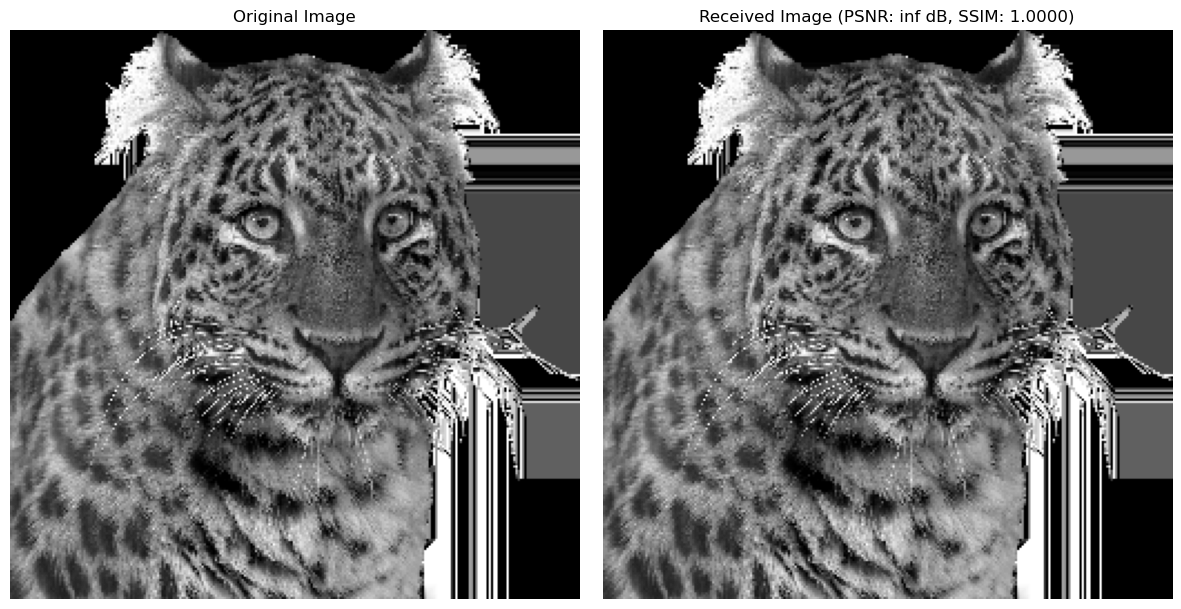

In [ ]:




## ============================================================================================================== ##
##                                                  SIMULATION RUN                                               ##
## ============================================================================================================== ##

img_path = "/home/rg9828/Documents/Blogger/Physical_Layer/PHYSICAL_Layer/OFDM/panther.png"

try:
    # 1. TRANSMITTER: Prepare signals for transmission.
    tx_symbols_per_user, img_shape, total_image_bits, coeff_info_per_user_list = \
        dwt_ofdm_transmitter(img_path, N_SUBCARRIERS, K, MOD_ORDER_BITS, WAVELET, CP_LENGTH)

    print(f"\nOriginal image shape: {img_shape}")
    print(f"Total image bits: {len(total_image_bits)}")
    print(f"Number of users: {K}")
    print(f"Number of BS antennas: {M_ANTENNAS}")
    print(f"Modulation: {2**MOD_ORDER_BITS}-PSK")
    
    # Display information about the transmitted blocks.
    if tx_symbols_per_user and len(tx_symbols_per_user[0]) > 0 and coeff_info_per_user_list[0]:
        num_blocks_per_user = len(coeff_info_per_user_list[0]) 
        block_len_flat_coeffs = coeff_info_per_user_list[0][0]['total_flattened_length']
        block_len_with_cp = block_len_flat_coeffs + CP_LENGTH
        print(f"Transmitting {num_blocks_per_user} DWT-OFDM blocks per user, each {block_len_with_cp} samples (with CP).")
    else:
        print("No transmission symbols generated (might be an issue with image size or N_SUBCARRIERS).")


    # 2. CHANNEL: Pass transmitted signals through the simulated realistic wireless channel.
    # The channel function requires coefficient info to correctly determine block lengths for noise application.
    rx_signals_at_antennas, H_channel, noise_variance_per_dim = \
        massive_mimo_channel(tx_symbols_per_user, M_ANTENNAS, K, SNR_DB, coeff_info_per_user_list) 

    # 3. RECEIVER: Process received signals to recover the image.
    recovered_img = dwt_ofdm_receiver(
        rx_signals_at_antennas, H_channel, noise_variance_per_dim, img_shape, 
        N_SUBCARRIERS, K, MOD_ORDER_BITS, WAVELET, CP_LENGTH, coeff_info_per_user_list, len(total_image_bits)
    )

    ## ============================================================================================================== ##
    ##                                                 EVALUATION & VISUALIZATION                                  ##
    ## ============================================================================================================== ##

    # Load and resize the original image for comparison.
    original_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    original_img_resized = cv2.resize(original_img, (N_SUBCARRIERS, N_SUBCARRIERS))

    # Convert images to float64 for PSNR/SSIM calculation (required by scikit-image).
    original_img_float = original_img_resized.astype(np.float64)
    recovered_img_float = recovered_img.astype(np.float64)

    # Calculate Peak Signal-to-Noise Ratio (PSNR).
    # PSNR measures image quality degradation. Higher is better (infinity for perfect).
    psnr_value = psnr(original_img_float, recovered_img_float, data_range=255.0)
    
    # Calculate Structural Similarity Index (SSIM).
    # SSIM measures perceptual similarity. Closer to 1.0 is better (1.0 for perfect).
    ssim_value = ssim(original_img_float, recovered_img_float, data_range=255.0)

    print(f"\n--- Realistic Channel Performance (SNR: {SNR_DB} dB) ---")
    print(f"PSNR: {psnr_value:.2f} dB")
    print(f"SSIM: {ssim_value:.4f}")

    # Plot original and recovered images for visual comparison.
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.imshow(original_img_resized, cmap='gray')
    plt.title('Original Image')
    plt.axis('off') # Hide axes for cleaner image display

    plt.subplot(122)
    plt.imshow(recovered_img, cmap='gray')
    plt.title(f'Received Image (PSNR: {psnr_value:.2f} dB, SSIM: {ssim_value:.4f})')
    plt.axis('off') # Hide axes
    plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
    plt.show()

# Error handling for file not found or other unexpected errors.
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure the image file '{img_path}' exists in the same directory.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

# END